## A.3: Final Report: SOTU

### Load Libraries

In [2]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# import nltk.download
# from nltk.download import stopwords

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ksenialuu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

### Function to process documents

In [4]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

###   Functions to label encoding

In [5]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [11]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/sotu_corpus_small.csv?token=AMCK53G7DSKFPVCNCOX63LS6KSE6Q")


In [12]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.head(5) 

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


### Processing text into lists

In [13]:

# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [14]:
# Note: the processed_text is the PROCESSED list of documents read directly form the csv
# Note the list of words is separated by commas

# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [15]:
# Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [16]:
# Verify TFIDF_Matrix has been created.

matrix.head(5)

,aaron,aaron associates,aaron associates measures,abandon,abandon blessings,abandon blessings distant,abandon cause,abandon cause liberty,abandon conquest,abandon conquest nature,...,zones bring,zones bring inner,zones broad,zones broad range,zones could,zones could birthday,zones means,zones means tenant,zones together,zones together theres
Reagan_1982.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.013268,0.013268,0.0,0.0,0.0,0.0,0.0,0.0
Wilson_1914.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Madison_1814.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Johnson_1969.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Hoover_1930.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

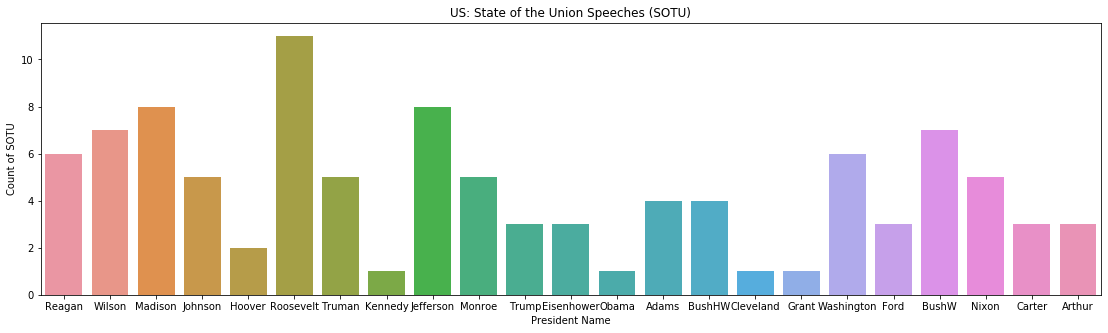

In [18]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore TFIDF Values

In [21]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

### Doc2Vec

In [22]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [23]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

In [24]:
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 america
 tonight
 budget
 world
 freedom
 people
 years
 american
 future
 americas
Cluster 0 titles: Reagan_1984.txt, Reagan_1985.txt, Reagan_1987.txt, Reagan_1986.txt, BushHW_1990.txt, BushHW_1989.txt, Reagan_1988.txt,Cluster 1:
 states
 united states
 united
 public
 government
 spain
 treaty
 commerce
 great
 shall
Cluster 1 titles: Madison_1815.txt, Madison_1816.txt, Madison_1813.txt, Monroe_1820.txt, Adams_1799.txt, Adams_1798.txt, Monroe_1822.txt, Monroe_1819.txt, Monroe_1818.txt, Washington_1791.txt, Adams_1800.txt, Washington_1793.txt, Washington_1792.txt, Monroe_1817.txt, Washington_1796.txt, Washington_1795.txt, Adams_1797.txt, Washington_1794.txt, Jefferson_1805.txt, Jefferson_1804.txt, Jefferson_1806.txt, Jefferson_1803.txt, Jefferson_1802.txt, Jefferson_1801.txt,Cluster 2:
 world
 nations
 people
 economic
 peace
 freedom
 production
 shall
 congress
 strength
Cluster 2 titles: Wilson_1917.txt, Truman_1948.txt, Kennedy_1963.txt, Eisenhow

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

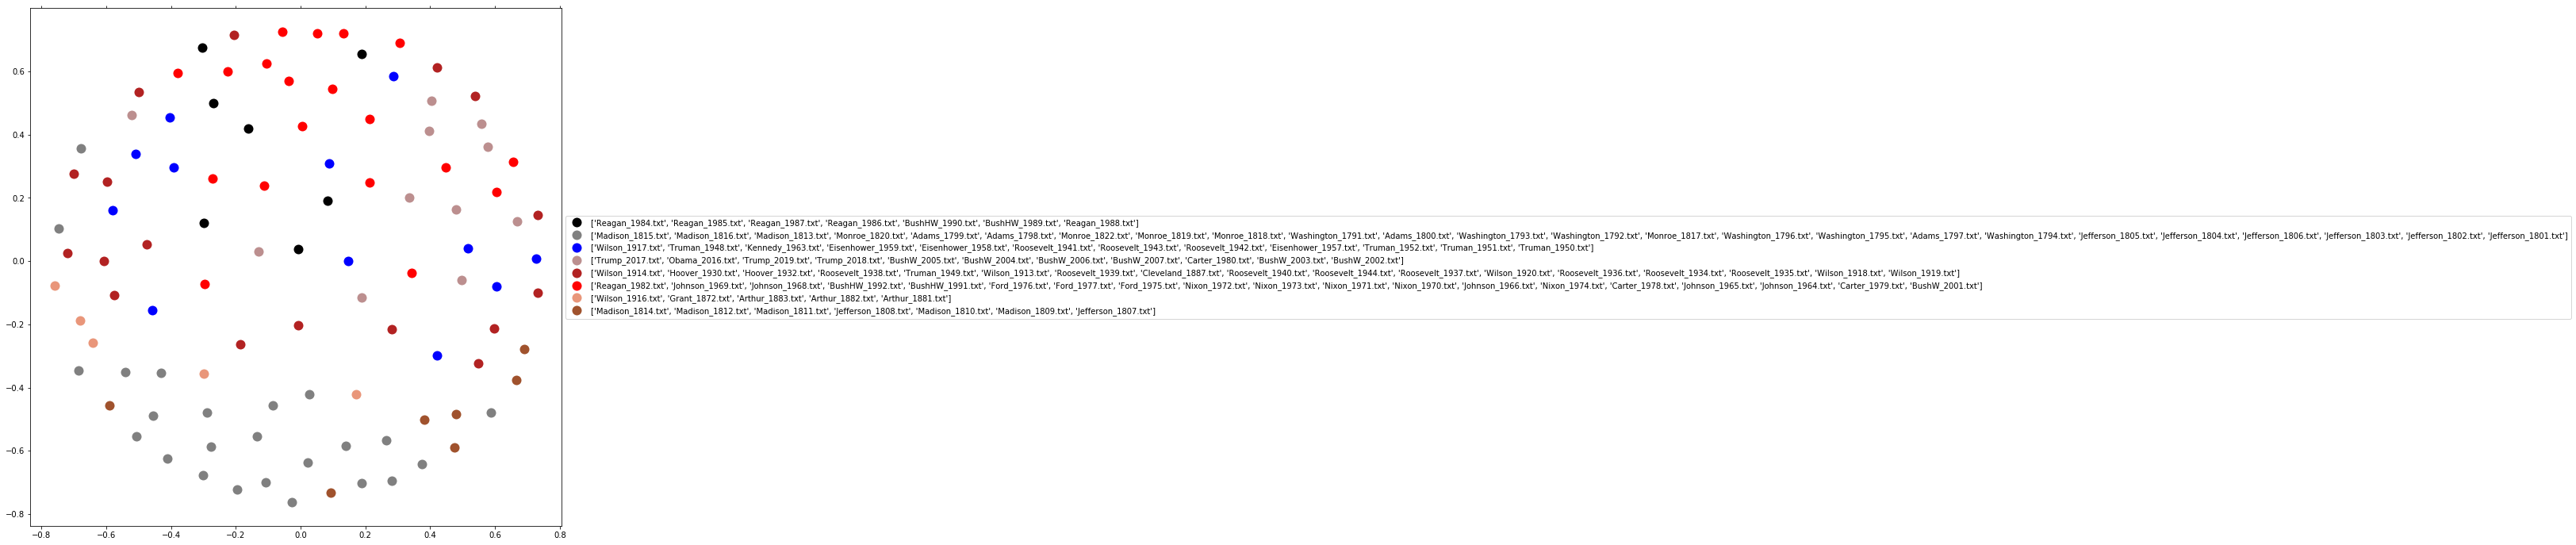

In [25]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

### K Means Clustering Doc2Vec
The following section of code is to run the k-means algorithm on the doc2vec outputs.

Note the differences in document clusters compared to the TFIDF matrix.

In [26]:
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

### Plotting Doc2vec
Convert two components as we're plotting points in a two-dimensional plane "precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

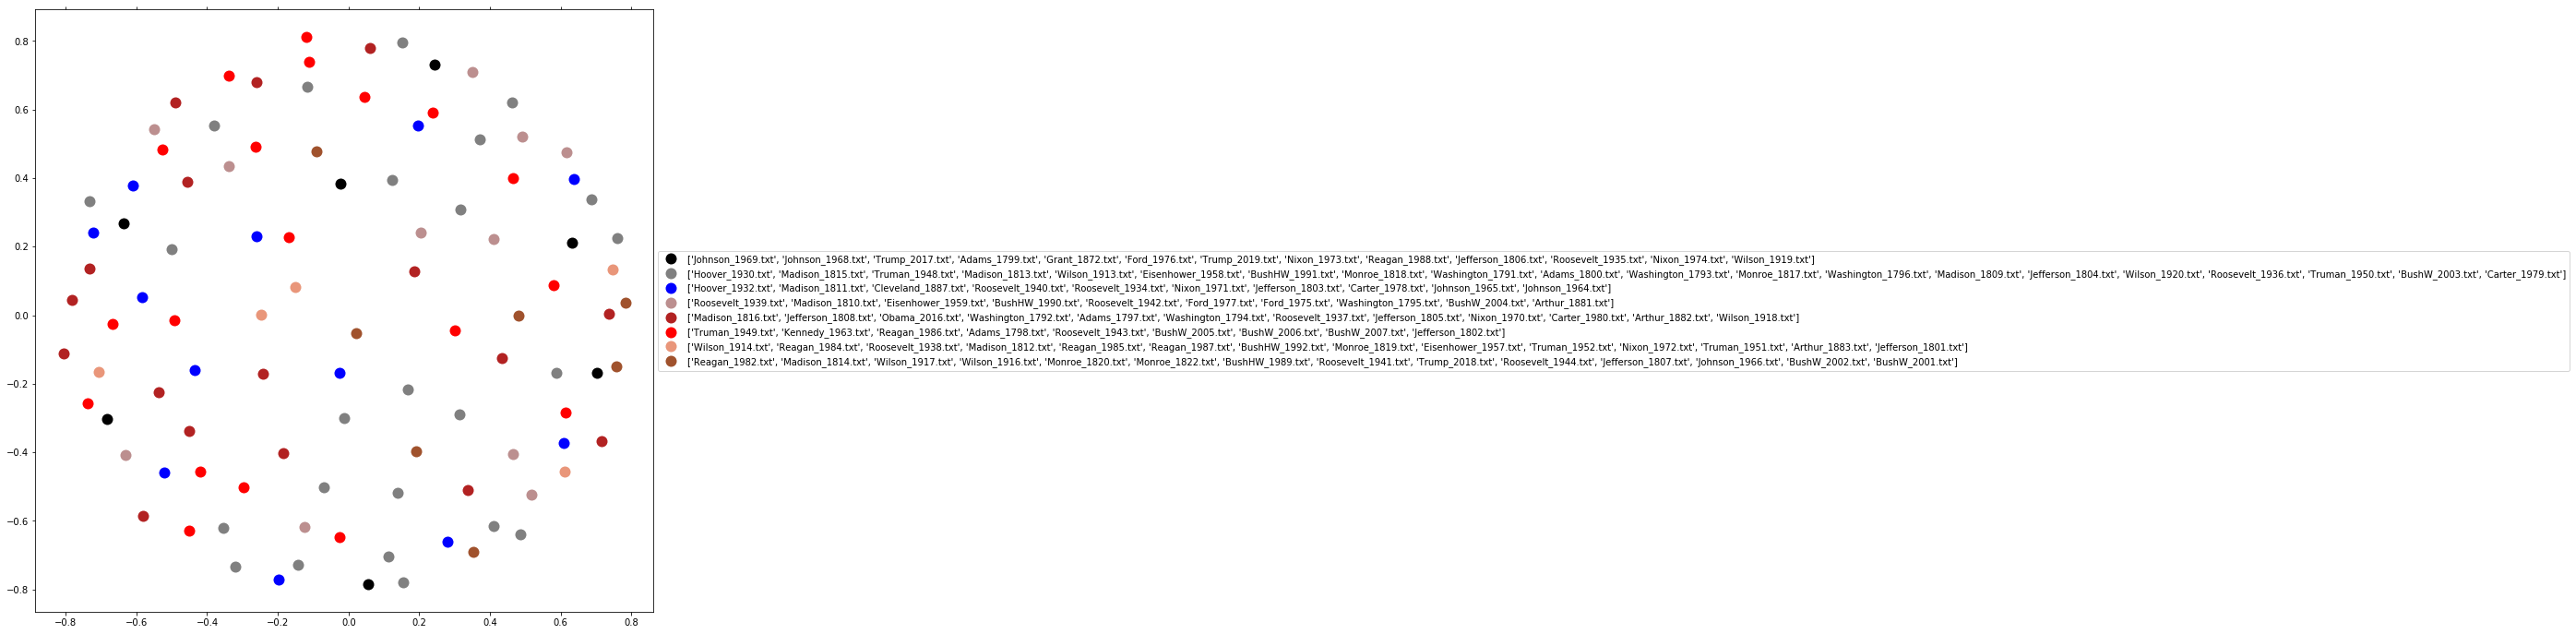

In [27]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [40]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

### Classification using various RF Model

The following section is used to create a model to predict the clusters labels based on the the TFIDF matrix and the doc2vec vectors.  

Note the model performance using the two different vectorization methods.

In [28]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X, Y, cv=5)

#mean CV score
np.mean(cv_score)

/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kseni

0.2137789661319073

In [62]:
# Trying few things out (Ali)

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(10, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(10, 'tf_corpus'))

Top 10 Terms based on document frequency.
               df_corpus
congress             102
states               102
government           101
united               101
country              100
nation               100
would                100
every                 99
great                 99
united states         99


Top 10 Terms based on frequency.
               tf_corpus
government          1152
people              1082
congress            1072
world               1059
states               954
united               866
great                783
american             751
united states        748
america              726
